In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from logistic_regression import LogisticRegressionGD
from extrapolation import *
from experiments import Experiment

In [3]:
data = pd.read_csv("../../../sonar.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [10]:
X = data.loc[:, data.columns[:-1]].values
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
y = data.loc[:, data.columns[-1]]
y = np.where(y == "R", 1, -1)

X = torch.tensor(X)
y = torch.tensor(y)

X.shape, y.shape

(torch.Size([208, 61]), torch.Size([208]))

In [5]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
model = LogisticRegressionGD(X_train, y_train, 1e-2)

In [7]:
model.fit(1e-4, max_iter=1000000)

In [8]:
preds = model.predict(X_test)
torch.mean((preds == y_test).double()).item()

0.8095238095238095

In [9]:
len(model.log)

24701

In [11]:
experiment = Experiment(model.log, model.obj, values=model.value_log)
k = 6

In [12]:
%%time
experiment.run_method("MPE+QR", MPE, k, method_kwargs={"qr": True})

CPU times: user 25.2 s, sys: 11.8 s, total: 37 s
Wall time: 10.3 s


In [13]:
%%time
experiment.run_method("RRE+QR", RRE, k, method_kwargs={"qr": True})

CPU times: user 19.6 s, sys: 9.3 s, total: 28.9 s
Wall time: 7.79 s


In [14]:
%%time
experiment.run_method("Regularized RRE", regularized_RRE, k, method_kwargs={"lambda_": 1e-15})

CPU times: user 25 s, sys: 11.7 s, total: 36.7 s
Wall time: 10.2 s


In [15]:
%%time
experiment.run_method("MMPE", MMPE, k)

CPU times: user 21.7 s, sys: 10.4 s, total: 32.1 s
Wall time: 10.7 s


In [16]:
%%time
experiment.run_method("TEA", TEA_solve, 2*k-1, input_size=k)

CPU times: user 30.7 s, sys: 15 s, total: 45.7 s
Wall time: 13.6 s


In [17]:
%%time
experiment.run_method("Epsilon inv", vector_epsilon_v1, 2*k, method_kwargs={"k": k})

CPU times: user 42.6 s, sys: 20 s, total: 1min 2s
Wall time: 18.6 s


In [18]:
%%time
experiment.run_method("Epsilon mult", vector_epsilon_v2, 2*k, method_kwargs={"k": k})

CPU times: user 2min 46s, sys: 1min 17s, total: 4min 3s
Wall time: 1min 15s


In [19]:
%%time
experiment.run_method("Topological epsilon", topological_vector_epsilon, 2*k, method_kwargs={"k": k})

CPU times: user 45.4 s, sys: 21.8 s, total: 1min 7s
Wall time: 20.4 s


In [20]:
%%time
q = torch.rand(X.shape[1], dtype=X.dtype, device=X.device)
q /= torch.linalg.norm(q, 2)
experiment.run_method("TEA_rand", TEA_solve, 2*k, input_size=k, method_kwargs={"q": q})

CPU times: user 26.9 s, sys: 12.9 s, total: 39.8 s
Wall time: 10.8 s


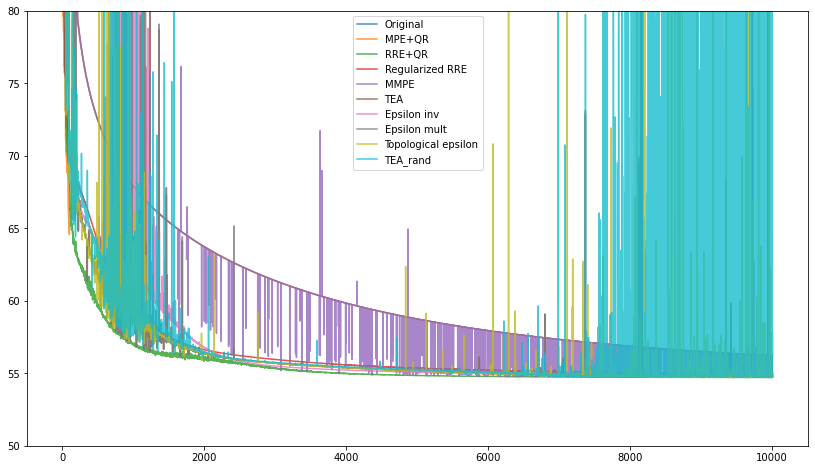

In [21]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000)
plt.ylim(50, 80)
plt.legend()

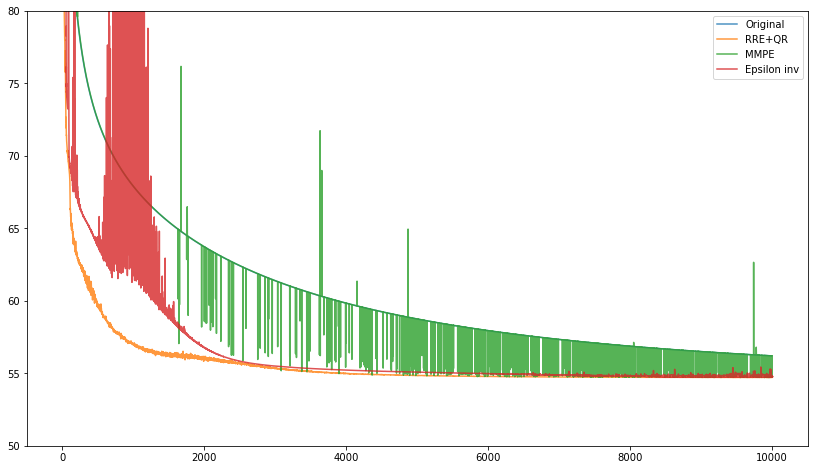

In [22]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["RRE+QR", "MMPE", "Epsilon inv"])
plt.ylim(50, 80)
plt.legend()

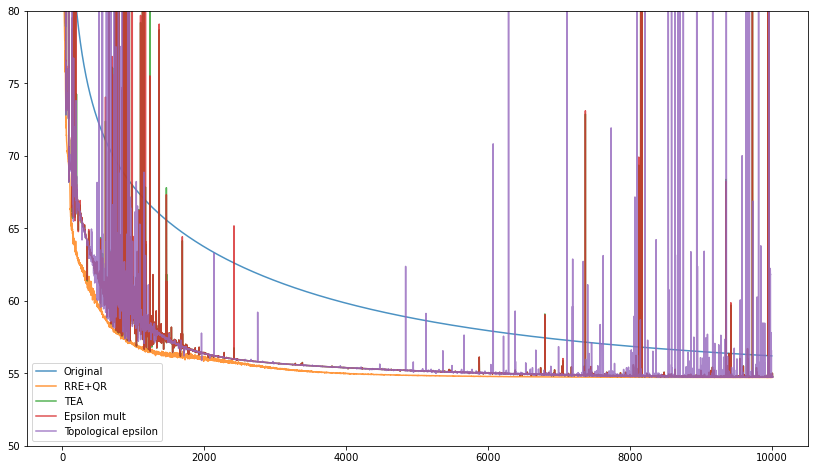

In [23]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["RRE+QR", "TEA", "Epsilon mult", "Topological epsilon"])
plt.ylim(50, 80)
plt.legend()

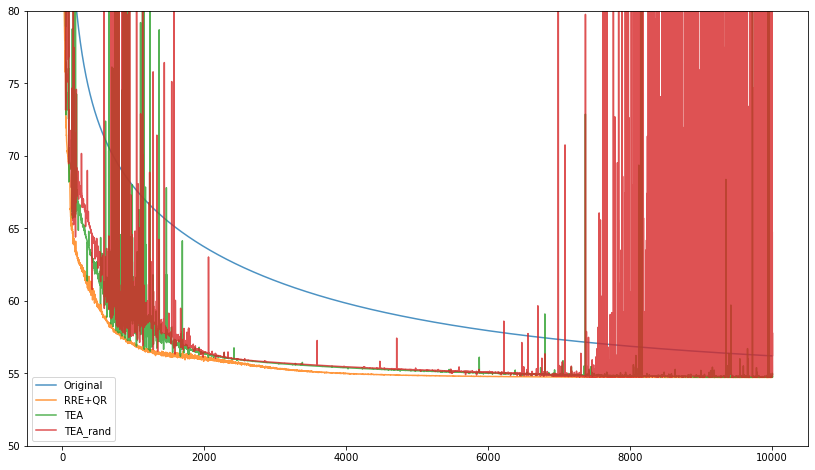

In [24]:
plt.figure(figsize=(14, 8))
experiment.plot_values(n=10000, methods=["RRE+QR", "TEA", "TEA_rand"])
plt.ylim(50, 80)
plt.legend()

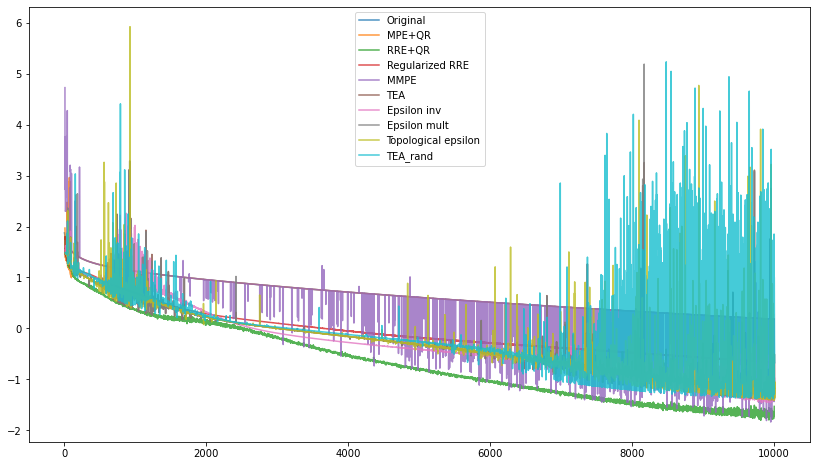

In [25]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000)
plt.legend()

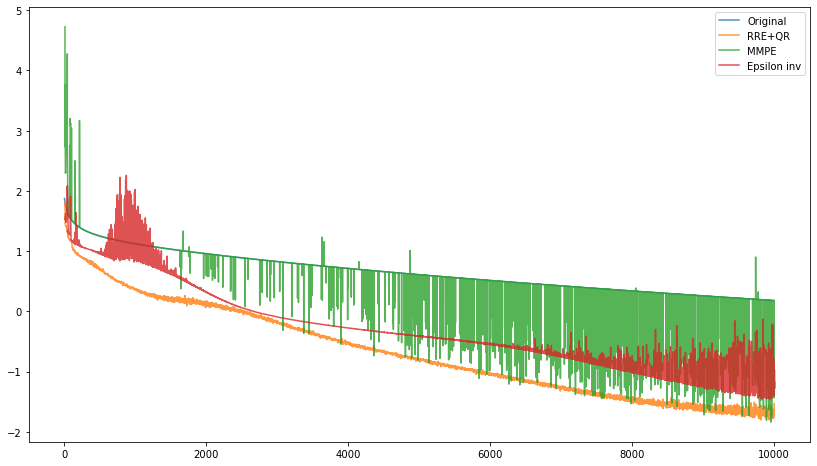

In [26]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["RRE+QR", "MMPE", "Epsilon inv"])
plt.legend()

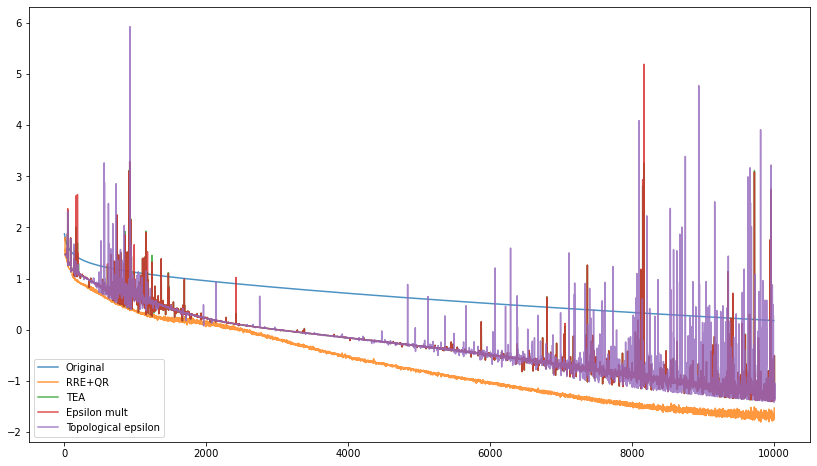

In [27]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["RRE+QR", "TEA", "Epsilon mult", "Topological epsilon"])
plt.legend()

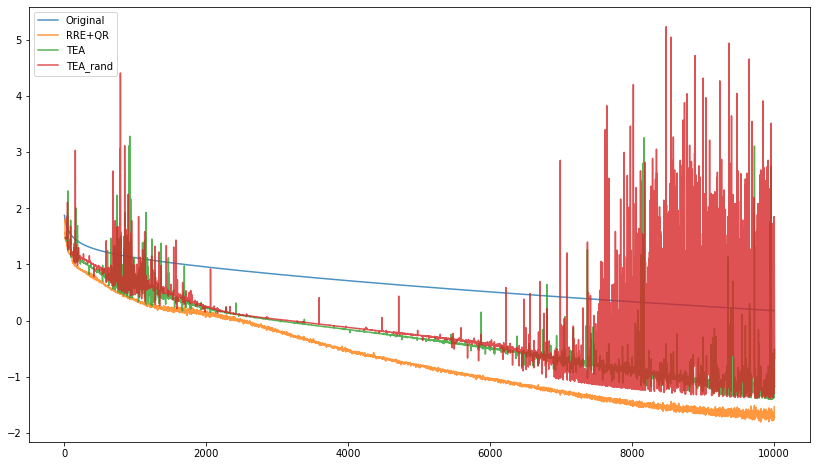

In [28]:
plt.figure(figsize=(14, 8))
experiment.plot_log_diff(n=10000, methods=["RRE+QR", "TEA", "TEA_rand"])
plt.legend()

In [29]:
model.theta = experiment.best_x
preds = model.predict(X_test)
torch.mean((preds == y_test).double()).item()

0.8095238095238095

In [29]:
df = experiment.value_df()
df.to_csv(f"results/sonar-new-methods:k={k}.csv")